# Soft Actor-Critic
**Stabiliztion of an orbitting particle**

### Import libraries

In [1]:
import jax
import jax.numpy as jnp
import jax.random as jrandom

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython.display import clear_output
import matplotlib.animation as animation
from matplotlib.gridspec import GridSpec
import pickle

# import local libraries
from environments.orbit import Orbital_SDI
from src.SoftActorCritic.main import SACAgent
import src.utilities.run_trial as rt

## Live plot particle

In [2]:
def training_animation(recording, dt, title, filename, **kwargs):
    theta, w = jnp.array(recording['state']).T
    Y = -jnp.cos(theta)
    X = jnp.sin(theta)
    angle = recording['angle']
    force = recording['force']
    #time = recording['time']

    n_iter = len(X)
    end_time = n_iter*dt
    time_horizon = np.arange(0, end_time, dt)
    bias = kwargs.get('bias', jnp.ones(n_iter))

    # initializing a figure
    fig = plt.figure(figsize=(12, 6))
    grid = GridSpec(nrows=3, ncols=3)
    ax1 = fig.add_subplot(grid[:2, 0])
    ax2 = fig.add_subplot(grid[0, 1:])
    ax3 = fig.add_subplot(grid[1, 1:])
    ax4 = fig.add_subplot(grid[2, :])
    ax = [ax1, ax2, ax3, ax4]

    ax[0].set(xlim=(-1.2, 1.2), ylim=(-1.2, 1.2))
    ax[1].set(xlim=(0, end_time))
    ax[2].set(xlim=(0, end_time))
    ax[3].set(xlim=(0, end_time), ylim=(-1.2, 1.2))

    # initializing a line variable
    theta_plot = np.linspace(-np.pi, np.pi, 100)
    ax[0].plot(np.cos(theta_plot), np.sin(theta_plot), c='r')
    point, = ax[0].plot([],[], marker="o", markersize=8, color='blue')
    ax[1].plot(time_horizon, angle)
    line1, = ax[1].plot([], [], color='r')
    ax[2].plot(time_horizon, force)
    line2, = ax[2].plot([], [], color='r')
    ax[3].plot(time_horizon, bias)
    line3, = ax[3].plot([], [], color='r')

    ax[0].set(title='Simulated particle')
    ax[1].set(xlabel='time', ylabel='controller angle')
    ax[1].grid()
    ax[2].set(xlabel='time', ylabel='controller force')
    ax[2].grid()
    ax[3].set(xlabel='time', ylabel='system bias')

    def animate(t):
        x_t = X[t]
        y_t = Y[t]
        point.set_data(x_t, y_t)
        line1.set_data([t*dt, t*dt], [-np.pi, np.pi])
        line2.set_data([t*dt, t*dt], [-np.pi, np.pi])
        line3.set_data([t*dt, t*dt], [-np.pi, np.pi])
        return [point, line1, line2]


    anim = animation.FuncAnimation(fig, animate, frames=n_iter, interval=20, blit=True)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle(title, fontsize=14)

    # save animation
    writervideo = animation.FFMpegWriter(fps=20)
    anim.save(f'{filename}.mp4', writer=writervideo)
    plt.close()


In [8]:
theta_plot = np.linspace(-np.pi, np.pi, 100)
x_plot = np.cos(theta_plot)
y_plot = np.sin(theta_plot)
def plot(x, y, it):
    clear_output(True)
    fig, ax = plt.subplots()
    ax.plot(x_plot, y_plot, c='r')
    ax.scatter(x, y, s=100)
    ax.set_xlim([-1.2, 1.2])
    ax.set_ylim([-1.2, 1.2])
    ax.set_title(f'iteration: {it:.0f}')
    plt.show()

In [10]:
# Animated plot as video
def anim_plot(X, Y, title=None, filename='Orbitting_particle'):
    n_iter = len(X)
    
    # initializing a figure
    fig, ax = plt.subplots()
    ax.set_xlim([-1.2, 1.2])
    ax.set_ylim([-1.2, 1.2])

    # initializing a line variable
    ax.plot(x_plot, y_plot, c='r')
    point, = ax.plot([],[], marker="o", markersize=8)

    def animate(t):
        x_t = X[t]
        y_t = Y[t]
        point.set_data(x_t, y_t)
        point.set_color('blue')
        return point,


    anim = animation.FuncAnimation(fig, animate, frames=n_iter, interval=20, blit=True)
    fig.suptitle(title, fontsize=14)

    # save animation
    writervideo = animation.FFMpegWriter(fps=20)
    anim.save(f'{filename}.mp4', writer=writervideo)
    plt.close()

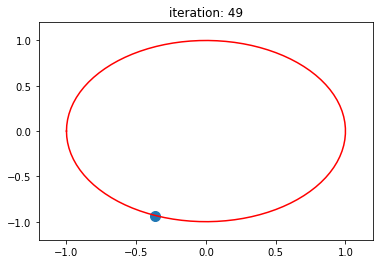

In [5]:
env = Orbital_SDI()
#env.state = jnp.array([0, 0])

control = -1
for it in range(50):
    observation, reward, done, _ = env.step(control)
    x, y, w =  observation
    plot(x, y, it)


## Initialization

In [2]:
def create_agent(key):
    # parameters
    memory_size = 1000
    batch_size = 128
    initial_random_steps = 200#1000

    control_limit = 4.
    obs_size = 2
    ctrl_size = 1

    env = Orbital_SDI(end_time=20)

    agent = SACAgent(
        env, memory_size, key, 
        initial_random_steps=initial_random_steps, 
        obs_size=obs_size, 
        ctrl_size=ctrl_size,
        control_limit=control_limit,
        epochs_per_step=10,
        lr=1e-2,
        memory_decay=5e-3
    )
    return agent

## Training

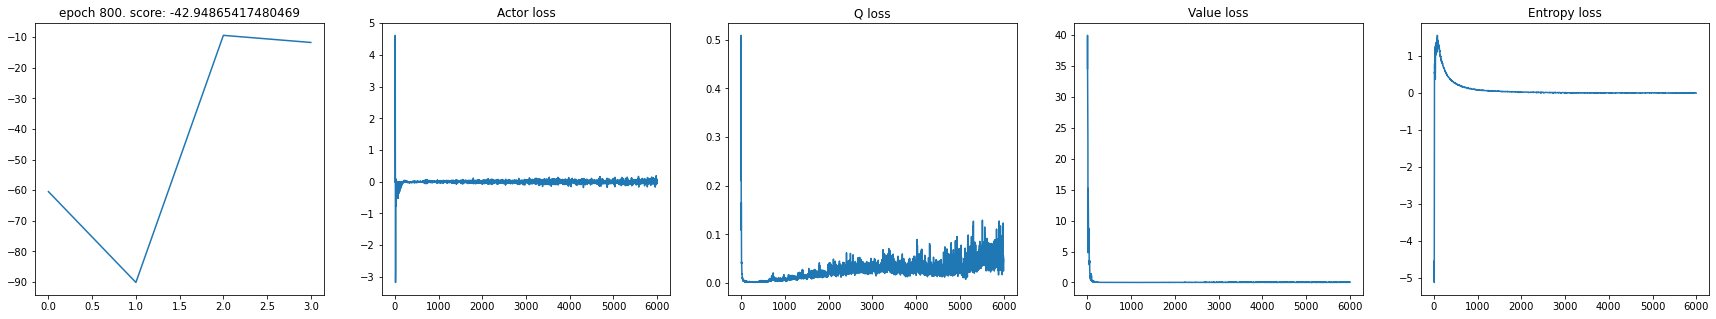

In [3]:
memory = {'recording':[], 'dt':[], 'seed':[]}
for seed in range(1):
    np.random.seed(seed)
    key = jrandom.PRNGKey(seed)

    agent = create_agent(key)

    agent.train(800, key, plotting_interval=200, record=True)
    #agent.env.B = agent.env.B * (-1)
    #agent.train(600, key, plotting_interval=200, record=True)
    #bias = [1 for _ in range(800)] + [-1 for _ in range(600)]

    #title = 'Live control using SAC'
    #filename = f'figures/system_variations/Live_controlled_orbiting_particle_{seed}'
    #training_animation(agent.recording, agent.env.dt, title, filename) #bias=bias

    memory['recording'].append(agent.recording)
    memory['dt'].append(agent.env.dt)
    memory['seed'].append(seed)


#file = open('figures/system_variations/data.pickle', 'wb')
#pickle.dump(memory, file)
#file.close()

#agent.train(800, key, plotting_interval=200, record=True)
#agent.env.B = -1 * agent.env.B
#agent.train(400, key, plotting_interval=200, record=True)

### Animated plot of training

In [11]:
def training_animation(recording, dt, title, filename, **kwargs):
    theta, w = jnp.array(recording['state']).T
    Y = -jnp.cos(theta)
    X = jnp.sin(theta)
    angle = recording['angle']
    force = recording['force']
    #time = recording['time']

    n_iter = len(X)
    end_time = n_iter*dt
    time_horizon = np.arange(0, end_time, dt)
    bias = kwargs.get('bias', jnp.ones(n_iter))

    # initializing a figure
    fig = plt.figure(figsize=(12, 6))
    grid = GridSpec(nrows=3, ncols=3)
    ax1 = fig.add_subplot(grid[:2, 0])
    ax2 = fig.add_subplot(grid[0, 1:])
    ax3 = fig.add_subplot(grid[1, 1:])
    ax4 = fig.add_subplot(grid[2, :])
    ax = [ax1, ax2, ax3, ax4]

    ax[0].set(xlim=(-1.2, 1.2), ylim=(-1.2, 1.2))
    ax[1].set(xlim=(0, end_time))
    ax[2].set(xlim=(0, end_time))
    ax[3].set(xlim=(0, end_time), ylim=(-1.2, 1.2))

    # initializing a line variable
    theta_plot = np.linspace(-np.pi, np.pi, 100)
    ax[0].plot(np.cos(theta_plot), np.sin(theta_plot), c='r')
    point, = ax[0].plot([],[], marker="o", markersize=8, color='blue')
    ax[1].plot(time_horizon, angle)
    line1, = ax[1].plot([], [], color='r')
    ax[2].plot(time_horizon, force)
    line2, = ax[2].plot([], [], color='r')
    ax[3].plot(time_horizon, bias)
    line3, = ax[3].plot([], [], color='r')

    ax[0].set(title='Simulated particle')
    ax[1].set(xlabel='time', ylabel='controller angle')
    ax[1].grid()
    ax[2].set(xlabel='time', ylabel='controller force')
    ax[2].grid()
    ax[3].set(xlabel='time', ylabel='system bias')

    def animate(t):
        x_t = X[t]
        y_t = Y[t]
        point.set_data(x_t, y_t)
        line1.set_data([t*dt, t*dt], [-np.pi, np.pi])
        line2.set_data([t*dt, t*dt], [-np.pi, np.pi])
        line3.set_data([t*dt, t*dt], [-np.pi, np.pi])
        return [point, line1, line2]


    anim = animation.FuncAnimation(fig, animate, frames=n_iter, interval=20, blit=True)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle(title, fontsize=14)

    # save animation
    writervideo = animation.FFMpegWriter(fps=20)
    anim.save(f'{filename}.mp4', writer=writervideo)
    plt.close()

title = 'Live control using SAC'
filename = 'figures/Live_controlled_orbiting_particle'
training_animation(agent.recording, agent.env.dt, title, filename)


### Phase plane

Text(0, 0.5, '$\\dot{\\theta}$')

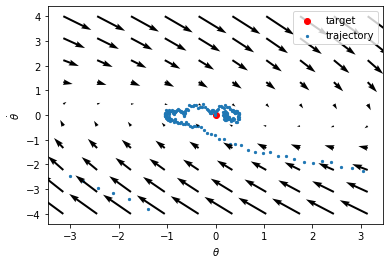

In [11]:
x0 = jnp.array([-1, -4])
S, _ = rt.run(agent, 20, x0=x0)

N = 10
#S = jnp.array(agent.recording['state'])

x_space = np.linspace(-np.pi, np.pi, N)
v_space = np.linspace(-4, 4, N)
xv, vv = np.meshgrid(x_space, v_space)
qx = np.zeros((N,N))
qv = np.zeros((N,N))

for i, x in enumerate(x_space):
  for j, v in enumerate(v_space):
    state = jnp.array([xv[i,j], vv[i,j]])
    control = agent.actor.model.predict(state)
    dx, dv = agent.env.predict_deriv(state, control)
    qx[i,j] = dx
    qv[i,j] = dv

fig, ax = plt.subplots()
ax.scatter(0, 0, c='r', label='target')
ax.scatter(S[:,0], S[:,1], s=5, label='trajectory')
ax.quiver(xv, vv, qx, qv)
ax.legend(loc=1)
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\dot{\theta}$')


## Results

### Networks surface plots

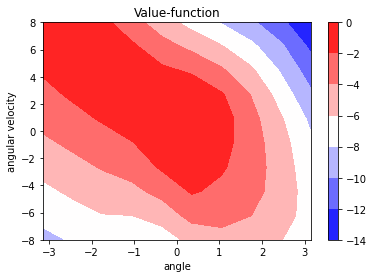

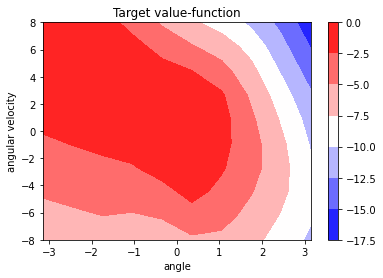

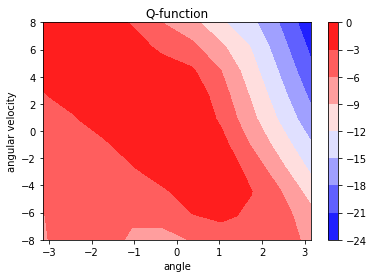

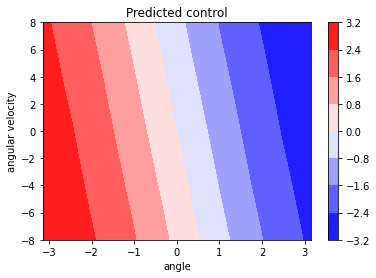

In [5]:
# Value and policy functions

N = 10
x_space = np.linspace(-np.pi, np.pi, N)
v_space = np.linspace(-8, 8, N)
xv, vv = np.meshgrid(x_space, v_space)
Q = np.zeros((N, N))
V = np.zeros((N, N))
V_target = np.zeros((N, N))
U = np.zeros((N, N))

for i, x in enumerate(x_space):
  for j, v in enumerate(v_space):
    #state = jnp.array([np.cos(x), np.sin(x), v])   # Cartesian coordinate system
    state = jnp.array([x, v])                       # Polar coordinate system
    control = jnp.array([0])
    V[i, j] = agent.VF(state)
    V_target[i, j] = agent.VF_target(state)
    Q[i, j] = agent.q_min(state, control)
    U[i, j] = agent.actor.model.predict(state)

fig, ax = plt.subplots()
plt.contourf(xv, vv, V, cmap=cm.bwr)
plt.colorbar()
plt.xlabel('angle')
plt.ylabel('angular velocity')
plt.title('Value-function')
plt.show()

fig, ax = plt.subplots()
plt.contourf(xv, vv, V_target, cmap=cm.bwr)
plt.colorbar()
plt.xlabel('angle')
plt.ylabel('angular velocity')
plt.title('Target value-function')
plt.show()

fig, ax = plt.subplots()
plt.contourf(xv, vv, Q, cmap=cm.bwr)
plt.colorbar()
plt.xlabel('angle')
plt.ylabel('angular velocity')
plt.title('Q-function')
plt.show()

fig, ax = plt.subplots()
plt.contourf(xv, vv, U, cmap=cm.bwr)
plt.colorbar()
plt.xlabel('angle')
plt.ylabel('angular velocity')
plt.title('Predicted control')
plt.show()


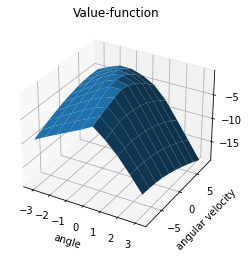

In [7]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xv, vv, V)
plt.xlabel('angle')
plt.ylabel('angular velocity')
plt.title('Value-function')
plt.show()

### Test trajectory

In [6]:
key = jrandom.PRNGKey(1)
env = Orbital_SDI()
env.state = jnp.array([jnp.pi, 0])

observation = env._get_obs(key)
for it in range(100):
    key, subkey = jrandom.split(key)
    control = agent.get_control(observation, key)
    observation, reward, done, _ = env.step(control, key=subkey)
    theta, w = observation      # Polar coordinate system
    x = jnp.cos(theta)
    y = jnp.sin(theta)
    #x, y, w = observation      # Cartesian coordinate system
    plot(y, -x, it)


NameError: name 'plot' is not defined

In [17]:
key = jrandom.PRNGKey(0)
N = 200

env = Orbital_SDI(end_time=20)

X_data = np.zeros(N)
Y_data = np.zeros(N)

observation = env._get_obs(key)
for it in range(N):
    key, subkey = jrandom.split(key)
    control = agent.get_control(observation, key)
    observation, reward, done, _ = env.step(control, key=subkey)
    x, y, w = observation

    X_data[it] = x
    Y_data[it] = y
    
    if done:
        X_data = X_data[:it]
        Y_data = Y_data[:it]
        break



In [20]:
#anim_plot(Y_data, -X_data, title='Controlled orbiting particle')